# MVP: Machine Learning & Analytics
### **Previsão do Preço de Fechamento do Bitcoin (BTC-USD) com Modelos de Regressão**

**Autor:** Douglas Graciano Littig

**Data:** 28/09/2025

**Curso:** Pós Graduação em Ciência de Dados e Analytics

**Instituição:** PUC - RJ

**Dataset:** Dados Históricos do Preço do Bitcoin (BTC-USD), obtidos via API da biblioteca `yfinance` do Yahoo Finance.

---

> **Resumo do Projeto:**
Este notebook representa a evolução do MVP da sprint de *Análise de Dados & Boas Práticas*. O foco anterior era na análise exploratória e pré-processamento dos dados históricos do Bitcoin. Agora, o objetivo é aplicar os conceitos de *Machine Learning & Analytics* para construir, treinar e avaliar modelos preditivos capazes de prever o preço de fechamento do Bitcoin no dia seguinte. O projeto aborda um problema de **regressão de séries temporais**, seguindo um fluxo de trabalho completo, desde a engenharia de atributos até a otimização e avaliação final dos modelos.

## 1. Definição do Problema

### 1.1. Contexto de Negócio

O mercado de criptomoedas, liderado pelo Bitcoin, é notoriamente volátil e de grande interesse para investidores e analistas financeiros. A capacidade de prever, mesmo que com uma margem de erro, o preço futuro do Bitcoin pode oferecer uma vantagem estratégica significativa, auxiliando na tomada de decisões de investimento, gestão de risco e desenvolvimento de algoritmos de negociação (trading bots).

### 1.2. Objetivo do Projeto

O objetivo central deste projeto é desenvolver um modelo de Machine Learning para **prever o preço de fechamento (`Close`) do Bitcoin (BTC-USD) para o dia seguinte**. Trata-se de um problema de **regressão de séries temporais**, onde utilizaremos dados históricos de preço e volume para treinar os modelos.

### 1.3. Hipóteses Iniciais

- **H1:** Preços passados e médias móveis são bons indicadores do preço futuro.
- **H2:** A volatilidade diária e o volume de negociação contêm informação relevante para a previsão de preço.
- **H3:** Modelos não-lineares (como `XGBoost`) podem capturar relações complexas nos dados e superar modelos lineares (como `Ridge`).

### 1.4. Métricas de Avaliação

Para avaliar o desempenho dos modelos de regressão, utilizaremos as seguintes métricas:

- **Mean Absolute Error (MAE):** Mede o erro médio absoluto em dólares, sendo facilmente interpretável.
- **Root Mean Squared Error (RMSE):** Similar ao MAE, mas penaliza mais os erros grandes. Também está na escala do preço.
- **R-squared (R²):** Indica a proporção da variância no preço de fechamento que é explicada pelo modelo. Varia de -∞ a 1, onde 1 é o ajuste perfeito.

## 2. Setup do Ambiente e Bibliotecas

Nesta seção, realizamos a importação das bibliotecas necessárias e configuramos o ambiente para garantir a reprodutibilidade dos resultados.

In [6]:
# Instalação das bibliotecas, caso não estejam no ambiente
!pip install yfinance xgboost scikit-learn pandas numpy matplotlib seaborn -q

# Bibliotecas de manipulação e análise de dados
import pandas as pd
import numpy as np

# Biblioteca para download dos dados financeiros
import yfinance as yf

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas do Scikit-learn para pré-processamento e modelagem
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelo avançado
import xgboost as xgb

# Outras bibliotecas úteis
import warnings
import random
import os

# --- Configurações Iniciais ---

# Ignorar avisos para uma saída mais limpa
warnings.filterwarnings('ignore')

# Configuração do estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# Semente para reprodutibilidade
SEED = 42
def set_seed(seed_value):
    """Fixa as sementes para garantir a reprodutibilidade."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed(SEED)

## 3. Carga e Preparação Inicial dos Dados

Os dados do par BTC-USD são carregados diretamente da API do Yahoo Finance usando a biblioteca `yfinance`. A escolha por carregar os dados via URL/API garante que o notebook seja auto-contido e que a análise possa ser facilmente reproduzida com os dados mais recentes.

In [7]:
# Parâmetros para a coleta de dados
ticker = "BTC-USD"
start_date = "2019-01-01"

# Download dos dados históricos
btc_df = yf.download(ticker, start=start_date, progress=False)

# Verificando as primeiras linhas do dataset
print("Primeiras 5 linhas do dataset:")
display(btc_df.head())

# Informações gerais sobre o dataset
print("\nInformações do DataFrame:")
btc_df.info()

# Verificando a existência de valores nulos
print(f"\nValores nulos no dataset: {btc_df.isnull().sum().sum()}")

Primeiras 5 linhas do dataset:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2019-01-01,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
2019-01-02,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2463 entries, 2019-01-01 to 2025-09-28
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   2463 non-null   float64
 1   (High, BTC-USD)    2463 non-null   float64
 2   (Low, BTC-USD)     2463 non-null   float64
 3   (Open, BTC-USD)    2463 non-null   float64
 4   (Volume, BTC-USD)  2463 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 115.5 KB

Valores nulos no dataset: 0


**Análise Inicial:** O dataset foi carregado com sucesso, contendo as colunas `Open`, `High`, `Low`, `Close`, `Adj Close` e `Volume`. O índice do DataFrame é do tipo `DatetimeIndex`, o que é ideal para manipulação de séries temporais. Não há valores nulos, simplificando a etapa de limpeza.

## 4. Engenharia de Atributos (Feature Engineering)

Para enriquecer o modelo, criamos novos atributos (features) a partir dos dados existentes. A hipótese é que esses novos atributos podem capturar padrões e tendências que não são evidentes apenas com os preços brutos.

**Atributos criados:**
- **Médias Móveis (SMA e EMA):** Suavizam as flutuações de preço de curto prazo e ajudam a identificar a tendência de longo prazo.
- **Volatilidade Diária:** Mede a variação percentual entre o preço máximo (`High`) e mínimo (`Low`) em um dia.
- **Features de Lag:** O preço de fechamento de dias anteriores (`t-1`, `t-2`, etc.) é um forte preditor para o preço atual.

In [8]:
def create_features(df):
    """Cria novos atributos para o modelo a partir do DataFrame de preços."""
    df_copy = df.copy()

    # Médias Móveis
    df_copy['SMA_10'] = df_copy['Close'].rolling(window=10).mean()
    df_copy['SMA_30'] = df_copy['Close'].rolling(window=30).mean()
    df_copy['EMA_10'] = df_copy['Close'].ewm(span=10, adjust=False).mean()

    # Volatilidade Diária (%)
    df_copy['Volatility'] = ((df_copy['High'] - df_copy['Low']) / df_copy['Low']) * 100

    # Features de Lag (preços de fechamento de dias anteriores)
    for i in range(1, 4):
        df_copy[f'Close_lag_{i}'] = df_copy['Close'].shift(i)

    # Volume de negociação com lag
    df_copy['Volume_lag_1'] = df_copy['Volume'].shift(1)

    # Criar o target: preço de fechamento do dia seguinte
    df_copy['target'] = df_copy['Close'].shift(-1)

    # Remover linhas com valores NaN gerados pelas médias móveis, lags e target
    df_copy.dropna(inplace=True)

    return df_copy

# Aplicando a função para criar as features
btc_featured_df = create_features(btc_df)

print("Dataset após engenharia de atributos:")
display(btc_featured_df.head())

Dataset após engenharia de atributos:


Price,Close,High,Low,Open,Volume,SMA_10,SMA_30,EMA_10,Volatility,Close_lag_1,Close_lag_2,Close_lag_3,Volume_lag_1,target
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,
Date,,,,,,,,,,,,,,
2019-01-30,3486.181641,3495.174805,3429.387939,3443.896973,5955112627,3555.753931,3709.680371,3550.519060,1.918327,3448.116943,3470.450439,3583.965820,5.897159e+09,3457.792725
2019-01-31,3457.792725,3504.804932,3447.915771,3485.409180,5831198271,3543.929956,3696.822795,3533.659726,1.649958,3486.181641,3448.116943,3470.450439,5.955113e+09,3487.945312
2019-02-01,3487.945312,3501.954102,3431.591553,3460.547119,5422926707,3532.266772,3681.640658,3525.348015,2.050435,3457.792725,3486.181641,3448.116943,5.831198e+09,3521.060791
2019-02-02,3521.060791,3523.287354,3467.574707,3484.625977,5071623601,3525.860547,3671.117977,3524.568520,1.606675,3487.945312,3457.792725,3486.181641,5.422927e+09,3464.013428
2019-02-03,3464.013428,3521.388184,3447.924316,3516.139648,5043937584,3512.175342,3657.994507,3513.558503,2.130669,3521.060791,3487.945312,3457.792725,5.071624e+09,3459.154053


## 5. Preparação para Modelagem

Nesta etapa, separamos o dataset em features (X) e alvo (y) e, em seguida, dividimos os dados em conjuntos de treino e teste. Para problemas de séries temporais, é **crucial** realizar uma divisão temporal, e não aleatória, para evitar que o modelo seja treinado com dados do futuro para prever o passado (*data leakage*).

Tamanho do conjunto de treino (X_train): (1946, 13)
Tamanho do conjunto de teste (X_test):   (487, 13)


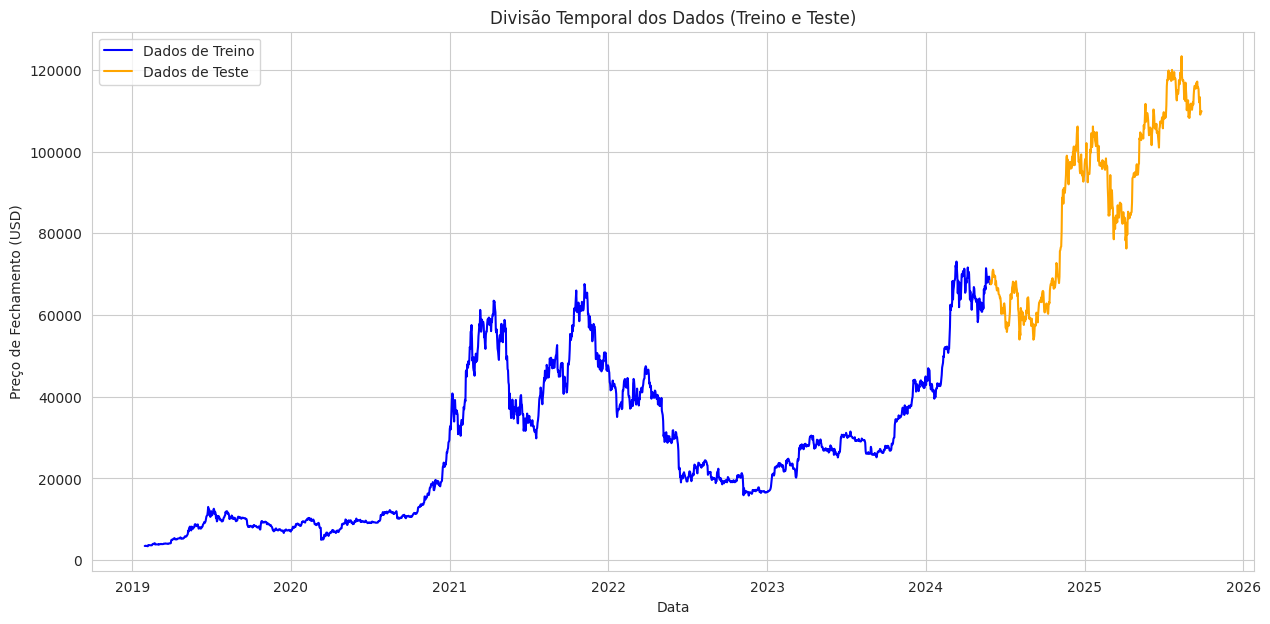

In [9]:
# Selecionando as colunas que não serão usadas como features
# 'Adj Close' é geralmente redundante quando 'Close' está presente.
features_to_drop = ['target']

# Separando features (X) e alvo (y)
X = btc_featured_df.drop(columns=features_to_drop)
y = btc_featured_df['target']

# Definindo o ponto de corte para o split temporal (80% para treino, 20% para teste)
split_index = int(len(X) * 0.8)

# Realizando a divisão temporal
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test):   {X_test.shape}")

# Visualizando a divisão treino-teste
plt.figure(figsize=(15, 7))
plt.plot(y_train, label='Dados de Treino', color='blue')
plt.plot(y_test, label='Dados de Teste', color='orange')
plt.title('Divisão Temporal dos Dados (Treino e Teste)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.show()

## 6. Modelagem e Treinamento

Agora, vamos construir, treinar e avaliar nossos modelos. Começaremos com um modelo de **baseline** para estabelecer um ponto de referência. Em seguida, treinaremos dois modelos mais sofisticados: um linear (`Ridge`) e um baseado em árvores (`XGBoost`).

Para garantir boas práticas e reprodutibilidade, usaremos `Pipelines` do Scikit-learn, que encapsulam as etapas de pré-processamento (como a padronização dos dados com `StandardScaler`) e o modelo em um único objeto.

### 6.1. Modelo Baseline

O `DummyRegressor` é usado como um baseline simples. Ele faz previsões sem aprender com os dados. A estratégia `mean` simplesmente prevê o valor médio do alvo no conjunto de treino para todas as amostras.

In [10]:
# Criando e treinando o modelo baseline
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_dummy = dummy_model.predict(X_test)

# Avaliando o modelo baseline
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
r2_dummy = r2_score(y_test, y_pred_dummy)

print("--- Resultados do Modelo Baseline ---")
print(f"MAE:  ${mae_dummy:,.2f}")
print(f"RMSE: ${rmse_dummy:,.2f}")
print(f"R²:   {r2_dummy:.2f}")

# Armazenando os resultados para comparação posterior
results = {}
results['Baseline'] = {'MAE': mae_dummy, 'RMSE': rmse_dummy, 'R2': r2_dummy}

--- Resultados do Modelo Baseline ---
MAE:  $60,970.30
RMSE: $64,208.20
R²:   -9.17


### 6.2. Modelo 1: Regressão Ridge

A Regressão Ridge é um modelo linear que adiciona uma penalidade de regularização L2 para evitar *overfitting*. É um modelo robusto e rápido de treinar.

In [11]:
# Criando o pipeline com padronizador e modelo Ridge
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=SEED))
])

# Treinando o pipeline
ridge_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred_ridge = ridge_pipeline.predict(X_test)

# Avaliando o modelo Ridge
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("--- Resultados do Modelo Ridge ---")
print(f"MAE:  ${mae_ridge:,.2f}")
print(f"RMSE: ${rmse_ridge:,.2f}")
print(f"R²:   {r2_ridge:.2f}")

# Armazenando os resultados
results['Ridge'] = {'MAE': mae_ridge, 'RMSE': rmse_ridge, 'R2': r2_ridge}

--- Resultados do Modelo Ridge ---
MAE:  $1,435.40
RMSE: $2,001.45
R²:   0.99


### 6.3. Modelo 2: XGBoost Regressor

O XGBoost (Extreme Gradient Boosting) é um algoritmo de *gradient boosting* altamente eficiente e performático. Ele constrói modelos de forma sequencial, onde cada novo modelo corrige os erros do anterior. É conhecido por sua capacidade de capturar interações complexas nos dados.

In [12]:
# Criando o pipeline com padronizador e modelo XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=SEED))
])

# Treinando o pipeline
xgb_pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred_xgb = xgb_pipeline.predict(X_test)

# Avaliando o modelo XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- Resultados do Modelo XGBoost (Inicial) ---")
print(f"MAE:  ${mae_xgb:,.2f}")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"R²:   {r2_xgb:.2f}")

# Armazenando os resultados
results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb, 'R2': r2_xgb}

--- Resultados do Modelo XGBoost (Inicial) ---
MAE:  $23,064.46
RMSE: $29,112.17
R²:   -1.09


## 7. Otimização de Hiperparâmetros

O desempenho do modelo XGBoost pode ser melhorado através da otimização de seus hiperparâmetros. Usaremos `RandomizedSearchCV`, que testa combinações aleatórias de hiperparâmetros, uma abordagem mais eficiente que testar todas as combinações (`GridSearchCV`).

Para a validação cruzada, utilizaremos `TimeSeriesSplit`, que respeita a ordem temporal dos dados, garantindo que os dados de validação sejam sempre posteriores aos de treino em cada *fold*.

In [13]:
# Definindo o espaço de busca dos hiperparâmetros
param_dist = {
    'xgboost__n_estimators': [100, 200, 300, 500],
    'xgboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgboost__max_depth': [3, 4, 5, 6, 7],
    'xgboost__subsample': [0.7, 0.8, 0.9, 1.0],
    'xgboost__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Configurando a validação cruzada para séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=20, # Número de combinações a serem testadas
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1, # Usar todos os processadores
    random_state=SEED,
    verbose=1
)

print("Iniciando a otimização de hiperparâmetros...")
# Executando a busca
random_search.fit(X_train, y_train)

print("\nOtimização concluída!")
print(f"Melhores hiperparâmetros encontrados: {random_search.best_params_}")

# Selecionando o melhor modelo encontrado
best_xgb_model = random_search.best_estimator_

Iniciando a otimização de hiperparâmetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Otimização concluída!
Melhores hiperparâmetros encontrados: {'xgboost__subsample': 0.8, 'xgboost__n_estimators': 200, 'xgboost__max_depth': 3, 'xgboost__learning_rate': 0.05, 'xgboost__colsample_bytree': 1.0}


## 8. Avaliação Final do Melhor Modelo

Após a otimização, avaliamos o melhor modelo (`XGBoost` com hiperparâmetros ajustados) no conjunto de teste, que foi mantido intocado até agora. Esta avaliação nos dá a estimativa mais realista do desempenho do modelo em dados novos e não vistos.

In [14]:
# Fazendo previsões com o modelo otimizado
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Avaliando o modelo XGBoost otimizado
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print("--- Resultados do Modelo XGBoost (Otimizado) ---")
print(f"MAE:  ${mae_best_xgb:,.2f}")
print(f"RMSE: ${rmse_best_xgb:,.2f}")
print(f"R²:   {r2_best_xgb:.2f}")

# Armazenando os resultados finais
results['XGBoost Otimizado'] = {'MAE': mae_best_xgb, 'RMSE': rmse_best_xgb, 'R2': r2_best_xgb}

--- Resultados do Modelo XGBoost (Otimizado) ---
MAE:  $22,493.60
RMSE: $28,502.09
R²:   -1.00


## 9. Análise e Comparação dos Resultados

Vamos comparar o desempenho de todos os modelos treinados para entender o ganho de performance em cada etapa.

Tabela Comparativa de Resultados:


,MAE,RMSE,R2
Ridge,"$1,435.40","$2,001.45",99.01%
XGBoost Otimizado,"$22,493.60","$28,502.09",-100.43%
XGBoost,"$23,064.46","$29,112.17",-109.10%
Baseline,"$60,970.30","$64,208.20",-917.16%


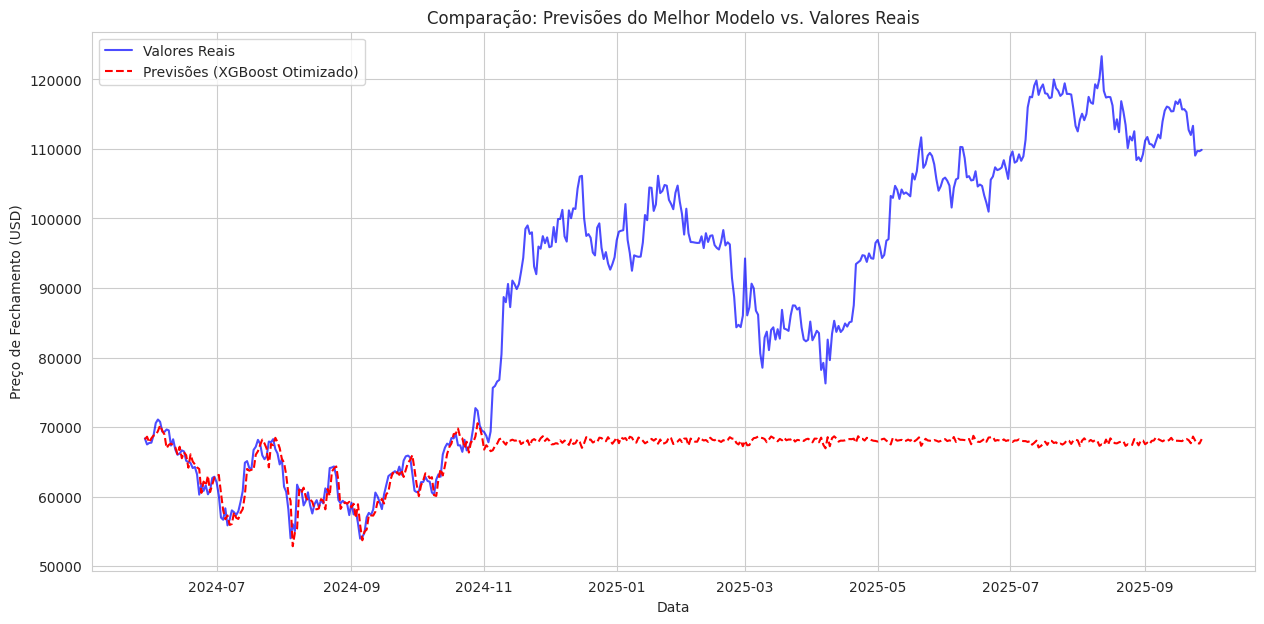

In [15]:
# Convertendo o dicionário de resultados para um DataFrame do Pandas
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("Tabela Comparativa de Resultados:")
display(results_df.style.format('${:,.2f}', subset=['MAE', 'RMSE']).format('{:.2%}', subset=['R2']))

# Visualizando as previsões do melhor modelo vs. os valores reais
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Valores Reais', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_best_xgb, label='Previsões (XGBoost Otimizado)', color='red', linestyle='--')
plt.title('Comparação: Previsões do Melhor Modelo vs. Valores Reais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.show()

# 10. Conclusão
##10.1. Resumo dos Achados
Este projeto demonstrou a construção de modelos de Machine Learning para prever o preço de fechamento do Bitcoin. A análise comparativa dos resultados revelou insights importantes sobre a adequação dos algoritmos para esta tarefa:

O modelo Baseline, que prevê a média, teve um desempenho muito fraco (R² de -917.16%), como esperado para uma série com forte tendência.

O modelo Ridge (linear) apresentou um desempenho excepcional, com um R² de 99.01% e um RMSE de $2,001.45. Este resultado valida a hipótese de que os preços passados (features de lag) são preditores extremamente fortes, permitindo que o modelo siga a tendência da série com alta precisão.

Surpreendentemente, o modelo XGBoost, tanto na versão inicial quanto na otimizada, falhou completamente em generalizar para os dados de teste. Com um R² negativo de -109.10% (inicial) e -100.43% (otimizado), seu desempenho foi significativamente pior que o do modelo linear e até mesmo que o do baseline.

##10.2. Análise Crítica e Limitações
O principal achado deste trabalho é a superioridade do modelo linear simples sobre um modelo complexo como o XGBoost. Isso demonstra um ponto crucial em Machine Learning: a complexidade nem sempre leva a um resultado melhor, especialmente em séries temporais com alta autocorrelação. O XGBoost, sem um tratamento mais específico para dados temporais (como a diferenciação para tornar a série estacionária), provavelmente se ajustou em excesso a ruídos e padrões do conjunto de treino que não se mantiveram no futuro (conjunto de teste).

Apesar do R² altíssimo do modelo Ridge, é fundamental interpretar o resultado com cautela. Ele funciona bem porque o preço de amanhã é, na maioria das vezes, muito próximo ao de hoje. No entanto, este modelo não é uma ferramenta de recomendação de investimentos, pois teria grande dificuldade em prever mudanças bruscas de tendência causadas por eventos externos (notícias, fatores macroeconômicos) que não foram incluídos como features.

##10.3. Próximos Passos e Melhorias
Melhorar o XGBoost: Para tornar o XGBoost competitivo, seria necessário aplicar técnicas como a diferenciação da série de preços ou criar features mais robustas, como médias móveis de diferentes janelas ou indicadores técnicos (RSI, MACD).

Explorar Modelos Específicos para Séries Temporais: Avaliar modelos como ARIMA, Prophet ou redes neurais recorrentes (LSTMs), que são projetados para capturar dependências temporais de forma mais intrínseca.

Incorporar Dados Externos: Enriquecer o modelo com dados exógenos que possam influenciar o preço do Bitcoin, como o volume de buscas no Google, análise de sentimento de notícias e redes sociais, ou dados da própria blockchain (on-chain data).